In [35]:
import sys
import os
sys.path.append(os.path.abspath("../"))  # or "../../" depending on location

In [36]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
# from utils.likelihood import *
from utils.formate_matrix_toMLData import *
from models.model_0929 import *
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.rcParams["font.size"] = 22
np.set_printoptions(suppress=True)


In [ ]:
# load virtual data
data_dir = "/media/user/TRANSCEND/datas/testdata_n800"
# data_dir = "/Volumes/TRANSCEND/datas/test_data"
test_states = []
test_del_t = []
test_targets = []
# dataset = []
formater = formate_dataMatrix()

# 読み込む対象の拡張子（例: .csv のみに限定）
VALID_EXTENSIONS = (".csv", ".txt")
IGNORED_PREFIXES = ("._", ".DS_Store", "Thumbs.db")

# ファイルを処理する関数
def process_file(file_path, states_sets, delt_sets, true_sets,targets_sets):
    try:
        print("Processing:", file_path)
        with open(file_path, 'rb') as f:
            all_matrix = np.loadtxt(f, delimiter=",")

        tm = matrix_trimer(all_matrix)
        true_trm = tm.trim_transitionRateMatrix(start = 0, end = 4)
        true_vec = np.array(formater.GetOutputVector_byDiagonal(true_trm))
        
        ll_trm = tm.trim_transitionRateMatrix(start = 4, end = 8)
        data = tm.trim_data(start = 8)
        output_vec = np.array(formater.GetOutputVector_byDiagonal(ll_trm))

        # state: shape (2, num_samples_i)
        state = np.stack([data[:, 0], data[:, 1]], axis=0)
        states_sets.append(state)
        delt_sets.append(data[:, 2])
        true_sets.append(true_vec)
        targets_sets.append(output_vec)

    except Exception as e:
        print(f"❌ Skipping file: {file_path} (Reason: {e})")

# ディレクトリ内のファイルを一括処理
def process_all_files_in_directory(directory, func, states_sets, delt_sets, targets_sets):
    for filename in os.listdir(directory):
        if filename.startswith(IGNORED_PREFIXES):
            continue
        if not filename.endswith(VALID_EXTENSIONS):
            continue

        file_path = os.path.join(directory, filename)
        if os.path.isfile(file_path):
            func(file_path,states_sets, delt_sets, targets_sets)

# 実行
process_all_files_in_directory(data_dir,process_file, test_states, test_del_t, test_targets)



# データセットとデータローダーの作成
test_dataset = varSets_Datasets(test_states, test_del_t, test_targets)
use_cuda = torch.cuda.is_available()
test_dataloader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn,
    pin_memory=use_cuda,
)
data_iter = iter(test_dataloader)

Processing: /media/user/TRANSCEND/datas/testdata_n800/12_800_4.csv
Processing: /media/user/TRANSCEND/datas/testdata_n800/62_800_4.csv
Processing: /media/user/TRANSCEND/datas/testdata_n800/36_800_4.csv
Processing: /media/user/TRANSCEND/datas/testdata_n800/11_800_4.csv
Processing: /media/user/TRANSCEND/datas/testdata_n800/15_800_4.csv
Processing: /media/user/TRANSCEND/datas/testdata_n800/1_800_4.csv
Processing: /media/user/TRANSCEND/datas/testdata_n800/50_800_4.csv
Processing: /media/user/TRANSCEND/datas/testdata_n800/16_800_4.csv
Processing: /media/user/TRANSCEND/datas/testdata_n800/2_800_4.csv
Processing: /media/user/TRANSCEND/datas/testdata_n800/28_800_4.csv
Processing: /media/user/TRANSCEND/datas/testdata_n800/7_800_4.csv
Processing: /media/user/TRANSCEND/datas/testdata_n800/65_800_4.csv
Processing: /media/user/TRANSCEND/datas/testdata_n800/57_800_4.csv
Processing: /media/user/TRANSCEND/datas/testdata_n800/21_800_4.csv
Processing: /media/user/TRANSCEND/datas/testdata_n800/17_800_4.cs

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model = DeepSets_varSets_forDiagnel(device=device)
model.load_state_dict(torch.load("../model_weights/mixed_distribution/mixed_0929.pth", map_location=device))
model.eval()

In [ ]:
#データセットごとの読み込み
dataset_list = [200,400,600,800,1000]
states_sets = []
del_t_sets = []
true_sets = []
targets_sets = []
for dataset_size in dataset_list:
    states = []
    del_ts = []
    trues = []
    targets = []
    process_all_files_in_directory(data_dir,process_file, states, del_ts, trues,targets)
    states_sets.append(states)
    del_t_sets.append(del_ts)
    true_sets.append(trues)
    targets_sets.append(targets)


    
    
    

In [39]:
loss_list = []
outs_lifespan = []
true_lifespan = []

class all_lifespan_loss(nn.Module):
    def forward(self, outputs, targets):
        epsilon = 1e-12
        y_pred_inverse = 1.0 / (outputs + epsilon)
        y_true_inverse = 1.0 / (targets + epsilon)

        # 逆数の差の絶対値
        loss_tensor = torch.abs(y_pred_inverse - y_true_inverse)[0]
        return loss_tensor, y_true_inverse[0], y_pred_inverse

criterion = all_lifespan_loss()

for states, delta_t, targets, lengths in data_iter:
    with torch.no_grad():
        states = states.to(device, non_blocking=True).long()
        delta_t = delta_t.to(device, non_blocking=True).float()
        targets = targets.to(device, non_blocking=True).float()
        lengths = lengths.to(device, non_blocking=True).long()

        outputs = model(states, delta_t, lengths)[0]
        loss_tensor, true_expect, pred_expect = criterion(outputs, targets)

        true_expect_cpu = true_expect.detach().cpu()
        pred_expect_cpu = pred_expect.detach().cpu()
        batch_loss = torch.abs(true_expect_cpu - pred_expect_cpu)

        true_lifespan.extend(true_expect_cpu.tolist())
        outs_lifespan.extend(pred_expect_cpu.tolist())
        loss_list.extend(batch_loss.tolist())

df = pd.DataFrame({
    "true": true_lifespan,
    "pred": outs_lifespan,
    "loss": loss_list,
})

In [ ]:
#データセットごとの推論
loss_lists = []
outs_lifespan_sets = []
ll_lifespan_sets = []
true_lifespan_sets = []

for i in range(len(dataset_list)):
    true_lifespan = []
    for j in range(len(true_sets[i])):
        true_vec = []
        for k in range(3):
            true_vec.append(1/true_sets[i][j][k])
        true_lifespan.append(true_vec)
    true_lifespan_sets.append(true_lifespan)

for i in range(len(dataset_list)):
    states = states_sets[i]
    del_ts = del_t_sets[i]
    targets = targets_sets[i]

    test_dataset = varSets_Datasets(states, del_ts, targets)
    use_cuda = torch.cuda.is_available()
    test_dataloader = DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=False,
        collate_fn=collate_fn,
        pin_memory=use_cuda,
    )
    data_iter = iter(test_dataloader)

    loss_list = []
    outs_lifespan = []
    ll_lifespan = []

    for states, delta_t, targets, lengths in data_iter:
        with torch.no_grad():
            states = states.to(device, non_blocking=True).long()
            delta_t = delta_t.to(device, non_blocking=True).float()
            targets = targets.to(device, non_blocking=True).float()
            lengths = lengths.to(device, non_blocking=True).long()

            outputs = model(states, delta_t, lengths)[0]
            loss_tensor, true_expect, pred_expect = criterion(outputs, targets)

            true_expect_cpu = true_expect.detach().cpu()
            pred_expect_cpu = pred_expect.detach().cpu()
            batch_loss = torch.abs(true_expect_cpu - pred_expect_cpu)

            true_lifespan.extend(true_expect_cpu.tolist())
            outs_lifespan.extend(pred_expect_cpu.tolist())
            loss_list.extend(batch_loss.tolist())

    loss_lists.append(loss_list)
    outs_lifespan_sets.append(outs_lifespan)
    ll_lifespan_sets.append(true_lifespan)

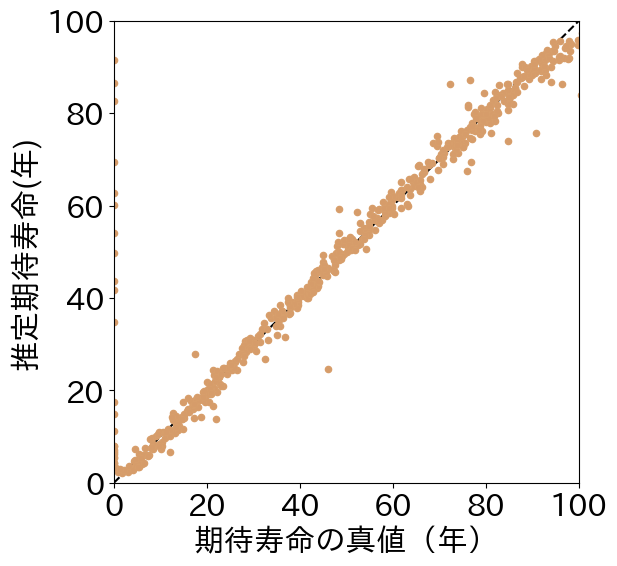

In [ ]:
plt.figure(figsize=(6,6))
x = np.linspace(0, 100, 1000)
color_list = ["#d69c6a", "#acf087", "#8fc8bb", "#6a7ed6", "#493bc4"]
plt.xlim(0,100)
plt.ylim(0,100)
plt.xlabel("期待寿命の真値（年）")
plt.ylabel("推定期待寿命(年)")
plt.plot(x,x,color="#000000", linestyle = '--',zorder= 0)
for i in range(len(dataset_list)):
    df = pd.DataFrame({
        "true": true_lifespan_sets[i],
        "pred": outs_lifespan_sets[i],
        "loss": loss_lists[i],
    })
    plt.scatter(df["true"],df["pred"],color = color_list[i],edgecolors=color_list[i],s = 20,  zorder= 1)
# plt.scatter(df["true"],df["pred"],color = "#d69c6a",edgecolors="#d79e6b",s = 20,  zorder= 1)


In [ ]:
gap_ll = []
gap_eval = []
for i in range(len(dataset_size)):
    l = []
    e = []
    for j in range(len(true_lifespan_sets[i])):
        for k in range(3):
            e.append(abs(true_lifespan_sets[i][j][k]-outs_lifespan_sets[i][j][k]))
            l.append(abs(true_lifespan_sets[i][j][k]-ll_lifespan_sets[i][j][k]))
    gap_ll.append(np.mean(l))
    gap_eval.append(np.mean(e))
            
    

In [ ]:
plt.boxplot(gap_ll)
plt.boxplot(gap_eval)
plt.show()

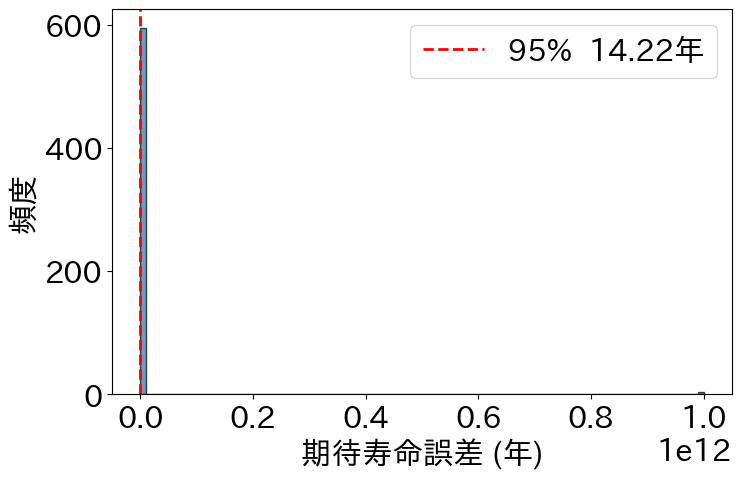

In [41]:
p95 = np.percentile(df["loss"], 95)

plt.figure(figsize=(8, 5))
plt.hist(df["loss"], bins=100, edgecolor="black", alpha=0.7)
plt.axvline(p95, color="red", linestyle="--", linewidth=2, label=f"95%  {p95:.2f}年")


plt.xlabel("期待寿命誤差 (年)")
plt.ylabel("頻度")
# plt.title("Histogram of Loss with 95th Percentile")
plt.legend()
plt.show()